In [1]:
from scipy.stats import norm
import numpy as np

import sys
path = "../"
sys.path.append(path)

from conversions import *
import proposals
import functions
import gnobs, models
import read_pe_samples
import analysis_data

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from importlib import reload

In [2]:
params = {'font.family': 'serif',
          'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large','font.size':15}
plt.rcParams.update(params)
inches_to_cm = 2.54
figsize = (40/inches_to_cm, 13/inches_to_cm)

In [5]:
# Read data
ifar_thr = 5.0
injections, pe = {}, {}
pe_dir = '../gw_data/o1o2_ifar5_phenompv2/*.hdf5'
pe['o1o2'] = read_pe_samples.read_pesamples(pe_dir, 7000)
pe_dir = '../gw_data/o3a_ifar5_phenompv2/*.hdf5'
pe['o3a'] = read_pe_samples.read_pesamples(pe_dir, 7000)

fname = '../gw_data/o1o2_bbhpop_siminj.hdf'
injections['o1o2'] = functions.read_injections_o1o2(fname)
fname = '../gw_data/o3a_bbhpop_inj_info.hdf'
injections['o3a'] = functions.read_injections_o3(fname, ifar_thr, 'aligned')

# Re-weight to a SFR
pe, injections = analysis_data.reweight_data_to_UinComov(pe, injections)

min_mch_prp, max_mch_prp = 1000, 0
for obsrun in injections.keys(): 
    for event in pe[obsrun].keys():
        min_mch_prp = min(min_mch_prp, np.percentile(pe[obsrun][event]['mchirp_src'], 1.))
        max_mch_prp = max(max_mch_prp, np.percentile(pe[obsrun][event]['mchirp_src'], 80.))

GW151012


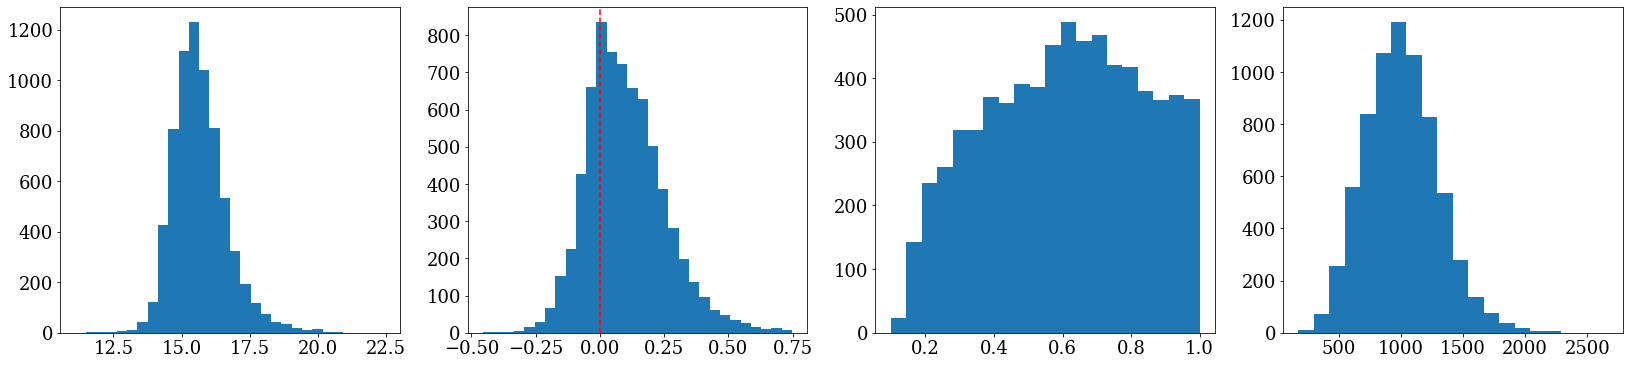

In [6]:
ii = 1
obsrun = 'o1o2'
events = list(pe[obsrun].keys())
data = pe[obsrun][events[ii]]
mch, mr = m1m2_to_mchq(data['mass1_src'], data['mass2_src'])
chieff = get_chieff(data['mass1_src'], data['mass2_src'], data['spin1z'], data['spin2z'])
obss1z, obss2z = data['spin1z'], data['spin2z']

fig = plt.figure(figsize = (7.0 * 4, 6.0))
plt.subplot(1, 4, 1)
xx = plt.hist(mch, bins = 30)
plt.subplot(1, 4, 2)
xx = plt.hist(chieff, bins = 30)
plt.axvline(x = 0, linestyle = '--', color = 'r')
plt.subplot(1, 4, 3)
xx = plt.hist(mr, bins = 20)
plt.subplot(1, 4, 4)
xx = plt.hist(data['lumd'], bins = 20)
print (events[ii])

In [7]:
max_spin = 0.99

max_dcdf_sz = 0.04
d_qmin = 0.05
qmin_prior = [0.05, 0.95]
d_alphaq = 0.3
alphaq_prior = [-6., 0.]
sz_prp_loc_scale = [0.0, 0.2]

min_nu, max_nu, nsamp = 100, 2000, 100
dof_prior = functions.get_dof(min_nu, max_nu, nsamp)

In [8]:
reload(functions)

<module 'functions' from '../functions.py'>

In [9]:
alphapar = 1.5
N, lkl = 3000, -1e9
fidl, fids = 0.0, 0.1
npl_mch, ngauss_sz = 1, 1#Made flexible to fit broken powerlaw for chirp mass and multiple Gaussians for spins
cdfs = np.linspace(0.0, 1.0, npl_mch + 1)
mcmeans = np.array([models.powerlaw_invcdf(c, min_mch_prp - .1, max_mch_prp + 1, alphapar) for c in cdfs])
alpha_mch = prp_alpha_mch = np.array(npl_mch * [alphapar])
mchpl_range = prp_mchpl_range = np.array([min_mch_prp, max_mch_prp])#mcmeans
qmin = 0.1
alpha_q = np.random.uniform(alphaq_prior[0], alphaq_prior[1])
locs_sz = ngauss_sz * [fidl]
scales_sz = ngauss_sz * [fids]

kk = 0
while kk < N:

    prp_mchpl_range = []
    prp_alpha_mch = np.random.normal(loc = alpha_mch, scale = 0.04)
    prp_mchpl_range = np.array([min_mch_prp, max_mch_prp])
        
    prp_qmin, prp_alpha_q = proposals.get_proposal_q_pl([qmin], [alpha_q], qmin_prior, \
                            alphaq_prior, d_qmin, d_alphaq)
    prp_qmin, prp_alpha_q = prp_qmin[0], prp_alpha_q[0]

    dof = np.random.choice(dof_prior, ngauss_sz)
    prp_locs_sz, prp_scales_sz, _, _ = proposals.get_proposal_spinz(locs_sz, scales_sz, dof, \
                                        sz_prp_loc_scale, max_dcdf_sz)
    
    selection = 0
    for obsrun in injections.keys():
        nobs = len(pe[obsrun].keys())
        vt, vterr = functions.get_vt_and_error_parametric_o3(injections[obsrun], prp_mchpl_range, prp_alpha_mch, \
                                                                     prp_qmin, prp_alpha_q, prp_locs_sz, prp_scales_sz)
        selection += nobs * np.log(vt)
    
    l = 0
    for obsrun in injections.keys():
        for event in pe[obsrun].keys():
            mchs = pe[obsrun][event]['mchirp_src']
            qs = pe[obsrun][event]['q']
            s1z = pe[obsrun][event]['spin1z']
            s2z = pe[obsrun][event]['spin2z']
            prpdf = pe[obsrun][event]['prior_pdf']
        
            prob_mch = models.broken_powerlaw_pdf(mchs, prp_mchpl_range, prp_alpha_mch)
            prob_q = models.powerlaw_pdf(qs, prp_qmin, 1.0, prp_alpha_q)
            prob_s1z = prob_s2z = 0
            for ii in range(ngauss_sz):
                prob_s1z += norm.pdf(s1z, loc = prp_locs_sz[ii], scale = prp_scales_sz[ii])
                prob_s2z += norm.pdf(s2z, loc = prp_locs_sz[ii], scale = prp_scales_sz[ii])
            prob_s1z /= ngauss_sz
            prob_s2z /= ngauss_sz
            l += np.log(np.sum(prob_mch * prob_q * prob_s1z * prob_s2z / prpdf / len(prob_mch)))
            
    l -= selection
        
    if l > 0.9999 * lkl:        
        mchpl_range = prp_mchpl_range
        alpha_mch = prp_alpha_mch
        qmin = prp_qmin
        alpha_q = prp_alpha_q
        locs_sz = prp_locs_sz
        scales_sz = prp_scales_sz
        lkl = max(l, lkl)
        
        print (kk, np.round(l, 2), np.round(lkl, 2))
        print (np.round(prp_mchpl_range, 2), np.round(prp_alpha_mch, 2))
        print (np.round(vt, 2))
        print ()
        
    kk += 1

0 1244.85 1244.85
[ 5.48 51.92] [1.42]
2.34

1 1244.89 1244.89
[ 5.48 51.92] [1.41]
2.36

2 1244.95 1244.95
[ 5.48 51.92] [1.41]
2.37

6 1245.19 1245.19
[ 5.48 51.92] [1.43]
2.34

7 1246.42 1246.42
[ 5.48 51.92] [1.51]
2.21

8 1247.0 1247.0
[ 5.48 51.92] [1.52]
2.22

9 1247.27 1247.27
[ 5.48 51.92] [1.58]
2.11

11 1248.18 1248.18
[ 5.48 51.92] [1.63]
2.01

14 1248.34 1248.34
[ 5.48 51.92] [1.65]
2.01

16 1248.6 1248.6
[ 5.48 51.92] [1.61]
2.1

17 1248.95 1248.95
[ 5.48 51.92] [1.64]
2.05

18 1249.23 1249.23
[ 5.48 51.92] [1.69]
1.96

20 1250.03 1250.03
[ 5.48 51.92] [1.73]
1.92

22 1250.54 1250.54
[ 5.48 51.92] [1.81]
1.81

26 1250.72 1250.72
[ 5.48 51.92] [1.8]
1.83

27 1250.85 1250.85
[ 5.48 51.92] [1.81]
1.81

28 1250.97 1250.97
[ 5.48 51.92] [1.8]
1.83

31 1251.52 1251.52
[ 5.48 51.92] [1.85]
1.76

33 1251.58 1251.58
[ 5.48 51.92] [1.86]
1.74

34 1252.22 1252.22
[ 5.48 51.92] [1.9]
1.7

35 1252.66 1252.66
[ 5.48 51.92] [1.96]
1.63

36 1252.72 1252.72
[ 5.48 51.92] [1.99]
1.6

38 12

In [10]:
mch_prp_ax = np.linspace(min_mch_prp - 0.5, max_mch_prp + 0.5, 1000)
sumhist_pe = 0
for key in pe.keys():
    for obs in pe[key].keys():
        hist, _ = np.histogram(pe[key][obs]['mchirp_src'], bins = mch_prp_ax, density = True)
        sumhist_pe += (hist / len(pe[key][obs]['mchirp_src']))
normh = 1 / np.sum(sumhist_pe) / (mch_prp_ax[1] - mch_prp_ax[0])

Text(0, 0.5, 'p(q)')

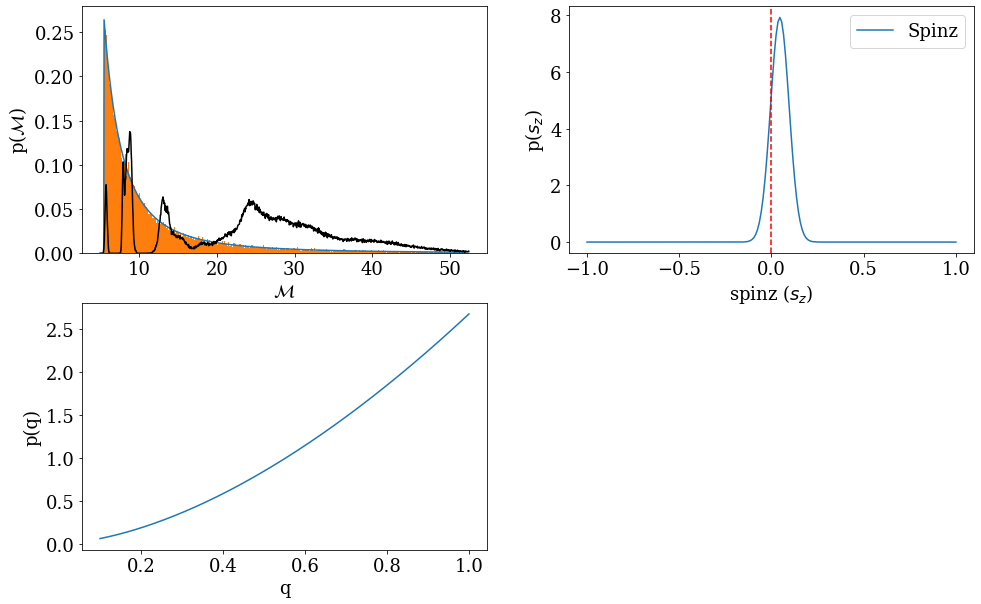

In [11]:
fig = plt.figure(figsize = (8.0 * 2, 5.0 * 2))
plt.subplot(2, 2, 1)
plt.plot(mch_prp_ax, models.broken_powerlaw_pdf(mch_prp_ax, mchpl_range, alpha_mch))
mchsamp = models.sample_broken_powerlaw(mchpl_range, alpha_mch, 100000)
xx = plt.hist(mchsamp, bins = mch_prp_ax, density = True)
plt.plot(0.5 * (mch_prp_ax[1:] + mch_prp_ax[:-1]), normh * sumhist_pe, color = 'black')
plt.xlabel("$\mathcal{M}$")
plt.ylabel("p($\mathcal{M}$)")
plt.subplot(2, 2, 2)
ax = np.linspace(-1, 1, 200)
pdfsz = sum(norm.pdf(ax, loc = locs_sz[ii], scale = scales_sz[ii]) for ii in range(ngauss_sz))
xx = plt.plot(ax, pdfsz, label = 'Spinz')
#plt.plot(ax, norm.pdf(xx[1], fidl, fids))
plt.xlabel('spinz ($s_z$)')
plt.ylabel('p($s_z$)')
plt.axvline(x = 0, color = 'r', linestyle = '--')
plt.legend()
plt.subplot(2, 2, 3)
ax = np.linspace(0.1, 1., 1000)
prob = models.powerlaw_pdf(ax, qmin, 1., alpha_q)
plt.plot(ax, prob)
plt.xlabel('q')
plt.ylabel('p(q)')
#plt.savefig('plots/refpop.jpg', dpi = 200, bbox  = 'tight')

In [12]:
print ('For r_eff')
print (np.round(mchpl_range, 3))
print (np.round(alpha_mch, 3))

For r_eff
[ 5.476 51.919]
[2.396]
